Epoch 1/100
264/264 [==============================] - 1s 2ms/step - loss: 4.4780 - mean_absolute_error: 1.6765 - val_loss: 4.6240 - val_mean_absolute_error: 1.6650
Epoch 2/100
264/264 [==============================] - 0s 2ms/step - loss: 4.0840 - mean_absolute_error: 1.5930 - val_loss: 4.2039 - val_mean_absolute_error: 1.5829
Epoch 3/100
264/264 [==============================] - 0s 1ms/step - loss: 3.7219 - mean_absolute_error: 1.5134 - val_loss: 3.8090 - val_mean_absolute_error: 1.4963
Epoch 4/100
264/264 [==============================] - 0s 1ms/step - loss: 3.3970 - mean_absolute_error: 1.4354 - val_loss: 3.4767 - val_mean_absolute_error: 1.4285
Epoch 5/100
264/264 [==============================] - 0s 1ms/step - loss: 3.1266 - mean_absolute_error: 1.3662 - val_loss: 3.1973 - val_mean_absolute_error: 1.3767
Epoch 6/100
264/264 [==============================] - 0s 1ms/step - loss: 2.8908 - mean_absolute_error: 1.3152 - val_loss: 2.9490 - val_mean_absolute_error: 1.3040
Epoch 7/10

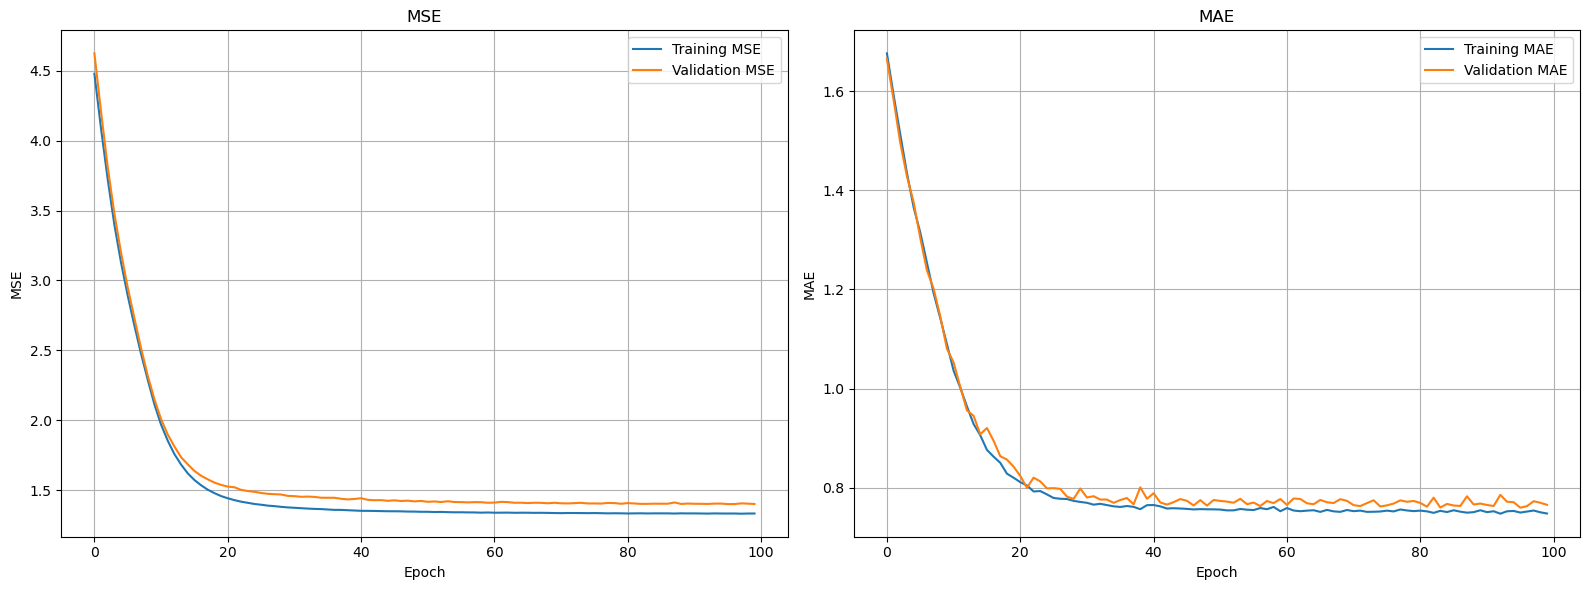

17/17 [==============================] - 0s 1ms/step
R-Squared Train Score 0.7034094620890966
R-Squared Test Score 0.7080993833681384


In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        # Create a trainable weight variable for the centers of the RBFs
        self.centers = self.add_weight(name='centers',
                                      shape=(self.units, input_shape[-1]),
                                      initializer='uniform',
                                      trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Calculate the radial basis functions for each input sample and each RBF center
        diff = K.expand_dims(inputs) - self.centers  # shape: (batch_size, units, input_dim)
        norm = K.sum(K.square(diff), axis=-1)  # shape: (batch_size, units)
        rbf = K.exp(-self.gamma * norm)  # shape: (batch_size, units)

        return rbf

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units
    

# Memuat dataset
df = pd.read_csv('datashotiqr/CB.csv', delimiter=',')
# Menentukan input(X) dan output (y)
X = df.drop(columns=["SHOT","GOAL","7MSHOT","6MSHOT","9MSHOT","WINGSHOT","PIVOTSHOT","FASTBREAKSHOT"])
y = df.GOAL
# Membagi dataset 80:20 untuk train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# normalisasi dataset agar tidak bias
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# membuat model neural network
model = Sequential()
model.add(Flatten(input_shape=(6,)))  # input layer dimana jumlah neuron sesuai dengan input
model.add(RBFLayer(6, 0.5)) # hidden layer dimana rbf kernel dijalankan dengan neuron sebanyak input dan nilai gamma
model.add(Dense(1, activation='linear'))  # aktivasi secara linear
model.compile(optimizer='rmsprop', loss=mean_squared_error,metrics=['mean_absolute_error']) 

history = model.fit(X_train, y_train, batch_size=8, epochs=100, validation_data=(X_test, y_test))

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)
print(f"R-Squared Train Score",r2_train)
print(f"R-Squared Test Score",r2_test)
